pendências
- [x] Procurar sobre importância de atributos
- [x] Calcular acurácia dos modelos
- [x] Fazer previsão por liga

# Imports e carregamentos

In [141]:
import pandas as pd
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [142]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

In [143]:
df.columns

Index(['homeTeam', 'awayTeam', 'shotsHome', 'shotsAway', 'league',
       'corners_home', 'corners_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'fouls_home', 'fouls_away', 'tackles_home', 'tackles_away', 'result',
       'match_id', 'possessiontime_away', 'possessiontime_home',
       'defensive_efficiency_home', 'defensive_efficiency_away',
       'possession_efficiency_home', 'possession_efficiency_away',
       'defensive_stability_home', 'defensive_stability_away',
       'attack_intensity_home', 'attack_intensity_away',
       'defensive_performance_home', 'defensive_performance_away',
       'game_progress_efficiency_home', 'game_progress_efficiency_away',
       'game_momentum_home', 'game_momentum_away', 'total_fouls'],
      dtype='object')

## Preprocessamento

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# # Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")

Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


## Rede Neural no Keras: Treinamento e Avaliação 

### Contrução do modelo, salvamento, visualização treino e teste

Epoch 1/500
1451/1451 [==============================] - 4s 2ms/step - loss: 0.5013 - accuracy: 0.7676 - recall_8: 0.7600 - precision_8: 0.7722 - val_loss: 0.4408 - val_accuracy: 0.7940 - val_recall_8: 0.7486 - val_precision_8: 0.8219
Epoch 2/500
1451/1451 [==============================] - 3s 2ms/step - loss: 0.4457 - accuracy: 0.7946 - recall_8: 0.7368 - precision_8: 0.8336 - val_loss: 0.4190 - val_accuracy: 0.8031 - val_recall_8: 0.7286 - val_precision_8: 0.8546
Epoch 3/500
1451/1451 [==============================] - 3s 2ms/step - loss: 0.4325 - accuracy: 0.8011 - recall_8: 0.7206 - precision_8: 0.8594 - val_loss: 0.4123 - val_accuracy: 0.8052 - val_recall_8: 0.7188 - val_precision_8: 0.8673
Epoch 4/500
1451/1451 [==============================] - 3s 2ms/step - loss: 0.4231 - accuracy: 0.8047 - recall_8: 0.7098 - precision_8: 0.8764 - val_loss: 0.4060 - val_accuracy: 0.8087 - val_recall_8: 0.7082 - val_precision_8: 0.8847
Epoch 5/500
1451/1451 [==============================] - 3s 

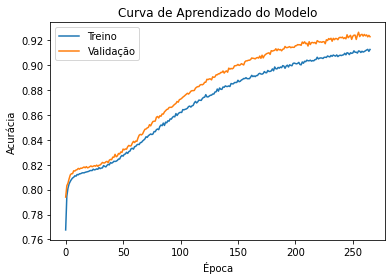

In [149]:
from sklearn.metrics import roc_auc_score
from keras.regularizers import l2
import tensorflow as tf  # Import the l2 regularizer

# , kernel_regularizer=l2(0.00005))) 

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.25)) 
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.00005)))  
model.add(Dense(1, activation='sigmoid'))

# Mantendo a taxa de aprendizado e o tamanho do batch do último ajuste
optimizer = Adam(learning_rate=0.00005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Aumentando a paciência no EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Paciência aumentada para permitir mais treinamento

# Treinando o modelo com mais épocas
history = model.fit(X_train, y_train, epochs=500, batch_size=64,  # Aumento do número de épocas
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht_final.h5')

In [150]:
from sklearn.metrics import classification_report
import numpy as np

# Fazendo as predições no conjunto de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0).flatten()  # Converter para 0s e 1s e achatar o array

# Obtendo os rótulos verdadeiros
y_true = y_test  # Substitua com o array correto de rótulos verdadeiros do conjunto de teste

# Gerando o relatório de classificação
report = classification_report(y_true, predictions, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


726/726 [==============================] - 1s 888us/step
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.94      0.92      0.93     11654
    Classe 1       0.92      0.94      0.93     11561

    accuracy                           0.93     23215
   macro avg       0.93      0.93      0.93     23215
weighted avg       0.93      0.93      0.93     23215



In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Carregar o modelo
model = load_model('../models/model_redeht_final.h5')

# Prever as probabilidades para o conjunto de teste
y_probs = model.predict(X_test)

# Inicialize o valor do threshold que você quer testar
thresholds = np.arange(0.1, 0.9, 0.01)

# Para cada threshold, calcule e imprima as métricas
for thresh in thresholds:
    # Converta probabilidades em previsões binárias com base no threshold
    y_pred = (y_probs >= thresh).astype(int)
    
    # Calcule as métricas para a classe 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Imprima as métricas
    print(f'Threshold: {thresh:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}')

# Escolha o threshold que oferece o melhor equilíbrio entre as métricas que são importantes para o seu caso de uso


726/726 [==============================] - 1s 832us/step
Threshold: 0.10, Precision: 0.723, Recall: 0.994, F1 Score: 0.837, Accuracy: 0.807
Threshold: 0.11, Precision: 0.733, Recall: 0.993, F1 Score: 0.843, Accuracy: 0.816
Threshold: 0.12, Precision: 0.742, Recall: 0.992, F1 Score: 0.849, Accuracy: 0.824
Threshold: 0.13, Precision: 0.751, Recall: 0.991, F1 Score: 0.855, Accuracy: 0.832
Threshold: 0.14, Precision: 0.759, Recall: 0.990, F1 Score: 0.859, Accuracy: 0.839
Threshold: 0.15, Precision: 0.767, Recall: 0.988, F1 Score: 0.864, Accuracy: 0.845
Threshold: 0.16, Precision: 0.774, Recall: 0.988, F1 Score: 0.868, Accuracy: 0.851
Threshold: 0.17, Precision: 0.781, Recall: 0.987, F1 Score: 0.872, Accuracy: 0.856
Threshold: 0.18, Precision: 0.787, Recall: 0.985, F1 Score: 0.875, Accuracy: 0.860
Threshold: 0.19, Precision: 0.795, Recall: 0.984, F1 Score: 0.879, Accuracy: 0.866
Threshold: 0.20, Precision: 0.802, Recall: 0.983, F1 Score: 0.883, Accuracy: 0.871
Threshold: 0.21, Precision: 0.

## Visualizando características importantes

In [ ]:
# from keras.models import load_model
# model = load_model('../models/model_redeht_final.h5')

# import shap
# # Criando o explainer
# explainer = shap.DeepExplainer(model, X_train)
# # Subconjunto do conjunto de teste para análise
# X_test_sample = X_test[:200]  # Ajuste o tamanho da amostra conforme necessário

# # Calculando os valores SHAP
# shap_values = explainer.shap_values(X_test_sample)
# # Plotando um gráfico de resumo
# # shap.summary_plot(shap_values, X_test_sample)

# # Obter os nomes das colunas numéricas
# numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# # Obter os nomes das colunas após a transformação
# # Para as características numéricas, permanecem os mesmos
# transformed_numeric_features = numeric_features

# # Como só tem uma característica categórica:
# categories = preprocessor.named_transformers_['cat'].categories_
# transformed_categorical_features = [
#     f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
# ]

# # Combina os dois
# all_transformed_features = transformed_numeric_features + transformed_categorical_features

In [ ]:
# # Plotando um gráfico de resumo com nomes de features reais
# shap.summary_plot(shap_values, features=X_test_sample, feature_names=all_transformed_features, max_display=X_test_sample.shape[1])